___

<a href='http://www.pieriandata.com'> <img src='../Pierian_Data_Logo.png' /></a>
___

# Natural Language Processing Project

Welcome to the NLP Project for this section of the course. In this NLP project you will be attempting to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews. This will be a simpler procedure than the lecture, since we will utilize the pipeline methods for more complex tasks.

We will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

Let's get started! Just follow the directions below!

## Imports
 **Import the usual suspects. :) **

In [43]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

## The Data

**Read the yelp.csv file and set it as a dataframe called yelp.**

In [2]:
yelp = pd.read_csv('yelp.csv')

** Check the head, info , and describe methods on yelp.**

In [3]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [5]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


**Create a new column called "text length" which is the number of words in the text column.**

In [6]:
yelp['text length'] = yelp['text'].apply(len)

**Use FacetGrid from the seaborn library to create a grid of 5 histograms of text length based off of the star ratings. Reference the seaborn documentation for hints on this**

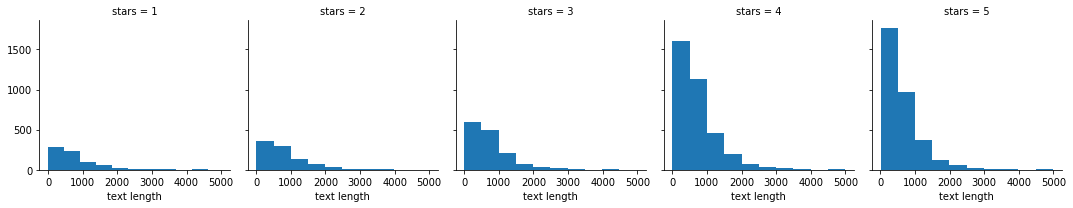

In [8]:
g = sns.FacetGrid(yelp,col="stars")
g = g.map(plt.hist, "text length")

**Create a boxplot of text length for each star category.**

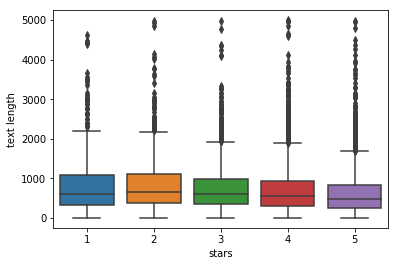

In [14]:
sns.boxplot(x='stars',y='text length',data=yelp)

**Create a countplot of the number of occurrences for each type of star rating.**

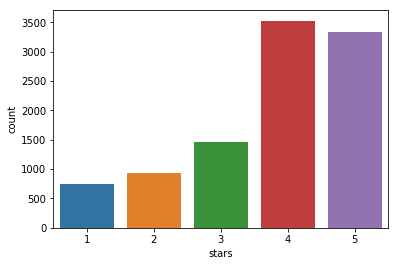

In [15]:
sns.countplot(data=yelp,x='stars')

** Use groupby to get the mean values of the numerical columns, you should be able to create this dataframe with the operation:**

In [20]:
stars = yelp.groupby('stars').mean()
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


**Use the corr() method on that groupby dataframe to produce this dataframe:**

In [21]:
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


**Then use seaborn to create a heatmap based off that .corr() dataframe:**

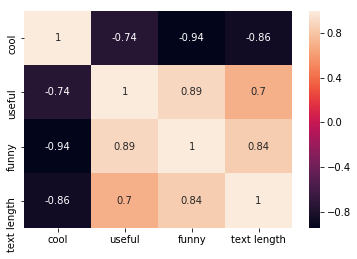

In [23]:
sns.heatmap(stars.corr(),annot=True)

## NLP Classification Task

Let's move on to the actual task. To make things a little easier, go ahead and only grab reviews that were either 1 star or 5 stars.

**Create a dataframe called yelp_class that contains the columns of yelp dataframe but for only the 1 or 5 star reviews.**

In [29]:
yelp_class = yelp[(yelp.stars == 1) | (yelp.stars == 5)]
yelp_class

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469
6,zp713qNhx8d9KCJJnrw1xA,2010-02-12,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...,review,wFweIWhv2fREZV_dYkz_1g,7,7,4,1565
9,nMHhuYan8e3cONo3PornJA,2010-08-11,jJAIXA46pU1swYyRCdfXtQ,5,Nobuo shows his unique talents with everything...,review,sUNkXg8-KFtCMQDV6zRzQg,0,1,0,186
10,AsSCv0q_BWqIe3mX2JqsOQ,2010-06-16,E11jzpKz9Kw5K7fuARWfRw,5,The oldish man who owns the store is as sweet ...,review,-OMlS6yWkYjVldNhC31wYg,1,3,1,298
11,e9nN4XxjdHj4qtKCOPq_vg,2011-10-21,3rPt0LxF7rgmEUrznoH22w,5,Wonderful Vietnamese sandwich shoppe. Their ba...,review,C1rHp3dmepNea7XiouwB6Q,1,1,0,321
12,h53YuCiIDfEFSJCQpk8v1g,2010-01-11,cGnKNX3I9rthE0-TH24-qA,5,They have a limited time thing going on right ...,review,UPtysDF6cUDUxq2KY-6Dcg,1,2,0,433
17,O510Re68mOy9dU490JTKCg,2010-05-03,j4SIzrIy0WrmW4yr4--Khg,5,okay this is the best place EVER! i grew up sh...,review,u1KWcbPMvXFEEYkZZ0Yktg,0,0,0,363


** Create two objects X and y. X will be the 'text' column of yelp_class and y will be the 'stars' column of yelp_class. (Your features and target/labels)**

In [34]:
X = yelp_class['text']
y = yelp_class['stars']

**Import CountVectorizer and create a CountVectorizer object.**

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

** Use the fit_transform method on the CountVectorizer object and pass in X (the 'text' column). Save this result by overwriting X.**

In [36]:
X = vectorizer.fit_transform(X)

## Train Test Split

Let's split our data into training and testing data.

** Use train_test_split to split up the data into X_train, X_test, y_train, y_test. Use test_size=0.3 and random_state=101 **

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

## Training a Model

Time to train a model!

** Import MultinomialNB and create an instance of the estimator and call is nb **

In [38]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

**Now fit nb using the training data.**

In [39]:
nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Predictions and Evaluations

Time to see how our model did!

**Use the predict method off of nb to predict labels from X_test.**

In [41]:
predictions = nb.predict(X_test)

** Create a confusion matrix and classification report using these predictions and y_test **

In [44]:
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[159  69]
 [ 22 976]]


              precision    recall  f1-score   support

           1       0.88      0.70      0.78       228
           5       0.93      0.98      0.96       998

   micro avg       0.93      0.93      0.93      1226
   macro avg       0.91      0.84      0.87      1226
weighted avg       0.92      0.93      0.92      1226



**Great! Let's see what happens if we try to include TF-IDF to this process using a pipeline.**

# Using Text Processing

** Import TfidfTransformer from sklearn. **

In [45]:
from sklearn.feature_extraction.text import TfidfTransformer

** Import Pipeline from sklearn. **

In [46]:
from sklearn.pipeline import Pipeline

** Now create a pipeline with the following steps:CountVectorizer(), TfidfTransformer(),MultinomialNB()**

In [47]:
pipeline = Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

## Using the Pipeline

**Time to use the pipeline! Remember this pipeline has all your pre-process steps in it already, meaning we'll need to re-split the original data (Remember that we overwrote X as the CountVectorized version. What we need is just the text**

### Train Test Split

**Redo the train test split on the yelp_class object.**

In [48]:
X = yelp_class['text']
y = yelp_class['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

**Now fit the pipeline to the training data. Remember you can't use the same training data as last time because that data has already been vectorized. We need to pass in just the text and labels**

In [49]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

### Predictions and Evaluation

** Now use the pipeline to predict from the X_test and create a classification report and confusion matrix. You should notice strange results.**

In [50]:
predictions = pipeline.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[  0 228]
 [  0 998]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

   micro avg       0.81      0.81      0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



/Users/alvinalaphat/PycharmProjects/datascience/venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Looks like Tf-Idf actually made things worse! That is it for this project. But there is still a lot more you can play with:

**Some other things to try....**
Try going back and playing around with the pipeline steps and seeing if creating a custom analyzer like we did in the lecture helps (note: it probably won't). Or recreate the pipeline with just the CountVectorizer() and NaiveBayes. Does changing the ML model at the end to another classifier help at all?

# Great Job!